# Prepare OAE dataset files for transfer to S3

23/09/2024

Aim: Create compressed copy of original dataset (on glade still), which can be directly uploaded to the Source Cooperative bucket

Requirements:
- Get the entire dataset down to ~50TB through compression and dropping variables
- **NEW** use integrations from Perlmutter when available
- Remove duplicated variables across simulations (i.e. those that don't vary with `polygon_id`)
- **NEW** Include both experimental and counterfactual data for every polygon
- Add polygon ids as an (integer) coordinate `polygon_id`
- Rename the polygon ids to 0 to 690 across the globe
- Add `injection_date` as a coordinate
- Rename `time` dimension to `elapsed_time`
- Reset `elapsed_time` coordinate to be an absolute date, consistent with `injection_date`
- Keep the same chunking so 3D variables will have ~30MB chunks
- Make sure any other encoding options are correct (i.e. time encoding)
- Run these steps in parallel on all ~500k files using `dask.delayed`

Later:
- Add auxiliary variables from the control run (as separate files to be merged into the dataset when kerchunking later)
- Include polygon masks (as a separate file but with correct ids - also to be merged when kerchunking)

In [1]:
from typing import List
import datetime
import re
import glob
from pathlib import Path

import cftime
import xarray as xr
import numpy as np
import dask
import pandas as pd

In [2]:
data_dir = '/glade/campaign/cesm/development/bgcwg/projects/OAE-Global-Efficiency/Mengyang_Global_OAE_Experiments/archive/'

In [3]:
perlmutter_data_dir = '/glade/campaign/cesm/development/bgcwg/projects/OAE-Global-Efficiency/Perlmutter-Integrations/'

(Should only use the model runs ending in `001` in this directory)

### Perlmutter Integrations

In [4]:
!pwd

/glade/u/home/tnicholas/oae_dataset/ResearchGrade/compressed_perlmutter


In [5]:
perlmutter_integrations = pd.read_csv(
    '/glade/u/home/tnicholas/oae_dataset/ResearchGrade/compressed_perlmutter/oae-simulations.csv'
)

In [6]:
perlmutter_integrations

,index,polygon,basin,start_date,polygon_id,rmse
0,0,0,North_Atlantic_basin,0347-04,0,11.042865
1,1,1,North_Atlantic_basin,0347-04,1,11.037806
2,2,2,North_Atlantic_basin,0347-04,2,11.037160
3,3,3,North_Atlantic_basin,0347-04,3,11.032843
4,4,4,North_Atlantic_basin,0347-04,4,11.041249
...,...,...,...,...,...,...
733,733,35,Southern_Ocean,0347-10,685,10.868375
734,734,36,Southern_Ocean,0347-10,686,10.871462
735,735,37,Southern_Ocean,0347-10,687,10.873281
736,736,38,Southern_Ocean,0347-10,688,10.870123


If, for a given `polygon_id` and `start_date`, there is a Perlmutter integration available, we should use that instead of Mengyang's original run.

In [7]:
def has_perlmutter_integration(new_polygon_id: str, injection_month: str) -> bool:
    """
    Checks if a given integration has an updated version run on Permutter.
    """
    # Convert new_polygon_id to integer
    new_polygon_id_int = int(new_polygon_id)
    
    matching_rows = perlmutter_integrations[
        (perlmutter_integrations['polygon_id'] == new_polygon_id_int) & 
        (perlmutter_integrations['start_date'].str.endswith(injection_month))
    ]
    return not matching_rows.empty

In [8]:
has_perlmutter_integration('000', '04')  # should return True

True

In [9]:
has_perlmutter_integration('000', '01')  # should return False

False

In [10]:
has_perlmutter_integration('088', '07')  # should return False

False

### Choice of variables

In [11]:
# Matt's breakdown of which variables are most important to keep
# Except I've separated out all counterfactual vars ("*_ALT" variables)
PRIORITY_0_VARS = [  # do not include (except from control run)
    "ECOSYS_ATM_PRESS",
    "ECOSYS_IFRAC",
    "ECOSYS_XKW",
    "IAGE",
    "Jint_100m_DIC",
    "SCHMIDT_CO2",
]
PRIORITY_1_VARS = [  # highest priority to include
    "ALK",
    "ALK_FLUX",
    "ALK_zint_100m",
    "ANGLE",
    "ANGLET",
    "ATM_CO2",
    "DCO2STAR",
    "DIC",
    "DIC_zint_100m",
    "DXT",
    "DXU",
    "DYT",
    "DYU",
    "DpCO2",
    "FG_CO2",
    "HT",
    "HTE",
    "HTN",
    "HU",
    "HUS",
    "HUW",
    "KMT",
    "KMU",
    "PH",
    "REGION_MASK",
    "STF_ALK",
    "T0_Kelvin",
    "TAREA",
    "TLAT",
    "TLONG",
    "UAREA",
    "ULAT",
    "ULONG",
    "cp_air",
    "cp_sw",
    "days_in_norm_year",
    "dz",
    "dzw",
    "fwflux_factor",
    "grav",
    "heat_to_PW",
    "hflux_factor",
    "latent_heat_fusion",
    "latent_heat_fusion_mks",
    "latent_heat_vapor",
    "mass_to_Sv",
    "momentum_factor",
    "nsurface_t",
    "nsurface_u",
    "ocn_ref_salinity",
    "omega",
    "pCO2SURF",
    "ppt_to_salt",
    "radius",
    "rho_air",
    "rho_fw",
    "rho_sw",
    "salinity_factor",
    "salt_to_Svppt",
    "salt_to_mmday",
    "salt_to_ppt",
    "sea_ice_salinity",
    "sflux_factor",
    "sound",
    "stefan_boltzmann",
    "time",
    "time_bound",
    "vonkar",
    "z_t",
    "z_t_150m",
    "z_w",
    "z_w_bot",
    "z_w_top",
]
PRIORITY_2_VARS = [
    "CO2STAR",
    "CO3",
    "H2CO3",
    "HCO3",
    "co3_sat_arag",
    "co3_sat_calc",
    "pH_3D",
    "tend_zint_100m_ALK",
    "tend_zint_100m_DIC",
]
PRIORITY_3_VARS = [  # lowest priority to include
    "ALK_RESTORE_TEND",
]

In [12]:
# variables which don't actually vary with polygon_id 
# i.e. anything with `_ALT` in it
# (though they arguably do vary with injection_date)
COUNTERFACTUAL_PRIORITY_0_VARS = [
    "ATM_ALT_CO2",
]
COUNTERFACTUAL_PRIORITY_1_VARS = [
    "ALK_ALT_CO2",
    "ALK_ALT_CO2_zint_100m",
    "DCO2STAR_ALT_CO2",
    "DIC_ALT_CO2",
    "DIC_ALT_CO2_zint_100m",
    "DpCO2_ALT_CO2",
    "FG_ALT_CO2",
    "PH_ALT_CO2",
    "STF_ALK_ALT_CO2",
    "pCO2SURF_ALT_CO2",
]
COUNTERFACTUAL_PRIORITY_2_VARS = [
    "CO2STAR_ALT_CO2",
    "CO3_ALT_CO2",
    # "H2CO3",
    # "HCO3",
    "co3_sat_arag",
    "co3_sat_calc",
    "pH_3D_ALT_CO2",
    "tend_zint_100m_ALK_ALT_CO2",
    "tend_zint_100m_DIC_ALT_CO2",
]
COUNTERFACTUAL_PRIORITY_3_VARS = [
    "ALK_ALT_CO2_RESTORE_TEND",
]
COUNTERFACTUAL_VARS = COUNTERFACTUAL_PRIORITY_0_VARS + COUNTERFACTUAL_PRIORITY_1_VARS + COUNTERFACTUAL_PRIORITY_2_VARS + COUNTERFACTUAL_PRIORITY_3_VARS

But loads of these data variables aren't really dependent data variables at all...

In [13]:
COORDS = [
    'dz',
    'dzw',
    'KMT',
    'KMU',
    'REGION_MASK',
    'UAREA',
    'TAREA',
    'HU',
    'HT',
    'DXU',
    'DYU',
    'DXT',
    'DYT',
    'HTN',
    'HTE',
    'HUS',
    'HUW',
    'time_bound',
    # everything beyond here are just like fundamental constants or conversion factors, do we actually need these?
    'ANGLE',
    'ANGLET',
    'days_in_norm_year',
    'grav',
    'omega',
    'cp_sw',
    'vonkar',
    'rho_air',
    'rho_sw',
    'rho_fw',
    'stefan_boltzmann',
    'latent_heat_vapor',
    'latent_heat_fusion',
    'latent_heat_fusion_mks',
    'ocn_ref_salinity',
    'sea_ice_salinity',
    'T0_Kelvin',
    'salt_to_ppt',
    'ppt_to_salt',
    'mass_to_Sv',
    'heat_to_PW',
    'salt_to_Svppt',
    'salt_to_mmday',
    'momentum_factor',
    'hflux_factor',
    'fwflux_factor',
    'salinity_factor',
    'sflux_factor',
    'nsurface_t',
    'nsurface_u',
    'radius',
    'sound',
    'cp_air',
]

In [14]:
VARS_TO_DROP = COUNTERFACTUAL_PRIORITY_0_VARS + COUNTERFACTUAL_PRIORITY_3_VARS + PRIORITY_0_VARS + PRIORITY_3_VARS + ['HCO3', 'H2CO3']

In [15]:
def open_single_file(
    filepath: str,
    original_polygon_id: str, 
    injection_month: str,
    region: str,
) -> xr.Dataset:

    #print(filepath)

    #filepath = data_dir + f'smyle-fosi.{region}.alk-forcing-{region}.{original_polygon_id}-1999-{injection_month}/ocn/hist/smyle-fosi.{region}.alk-forcing-{region}.{original_polygon_id}-1999-{injection_month}.pop.h.{year}-{month}.nc'
    
    ds = xr.open_dataset(
        filepath,
        drop_variables=VARS_TO_DROP,
    )

    return ds.set_coords(COORDS)

In [16]:
%%time
ds = open_single_file(
    filepath=data_dir + f'smyle-fosi.South.alk-forcing-South.250-1999-01/ocn/hist/smyle-fosi.South.alk-forcing-South.250-1999-01.pop.h.0347-01.nc',
    original_polygon_id='001',
    injection_month='01',
    region='South',
)

CPU times: user 469 ms, sys: 172 ms, total: 641 ms
Wall time: 4.64 s


In [17]:
ds

<xarray.Dataset> Size: 327MB
Dimensions:                     (time: 1, d2: 2, z_t: 60, z_t_150m: 15,
                                 z_w: 60, z_w_top: 60, z_w_bot: 60, nlat: 384,
                                 nlon: 320)
Coordinates: (12/61)
    time_bound                  (time, d2) object 16B ...
  * time                        (time) object 8B 0347-02-01 00:00:00
  * z_t                         (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                    (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                         (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                     (z_w_top) float32 240B 0.0 1e+03 ... 5.25e+05
    ...                          ...
    hflux_factor                float64 8B ...
    fwflux_factor               float64 8B ...
    salinity_factor             float64 8B ...
    sflux_factor                float64 8B ...
    nsurface_t                  float64 8B ...
    nsurface_u                  float64 8B ...
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/34)
    CO3                         (time, z_t, nlat, nlon) float32 29MB ...
    pH_3D                       (time, z_t, nlat, nlon) float32 29MB ...
    CO3_ALT_CO2                 (time, z_t, nlat, nlon) float32 29MB ...
    pH_3D_ALT_CO2               (time, z_t, nlat, nlon) float32 29MB ...
    co3_sat_calc                (time, z_t, nlat, nlon) float32 29MB ...
    co3_sat_arag                (time, z_t, nlat, nlon) float32 29MB ...
    ...                          ...
    ALK_ALT_CO2_zint_100m       (time, nlat, nlon) float32 492kB ...
    STF_ALK_ALT_CO2             (time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC          (time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC_ALT_CO2  (time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK          (time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK_ALT_CO2  (time, nlat, nlon) float32 492kB ...
Attributes:
    title:             smyle-fosi.South.alk-forcing-South.250-1999-01
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-09-15 at 23:22:59.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

### Add coordinate information

In [18]:
def add_polygon_id_coord(ds: xr.Dataset, new_polygon_id: str) -> xr.Dataset:

    # add as an integer coordinate
    polygon_id_coord = xr.DataArray(
        name='polygon_id', 
        dims='polygon_id', 
        data=[int(new_polygon_id)], 
        attrs={'long_name': "polygon ID"},
    )
    
    return ds.assign_coords(
        polygon_id=polygon_id_coord,
    )

In [19]:
ds_with_polygon_id = add_polygon_id_coord(ds, new_polygon_id='000')

In [20]:
ds_with_polygon_id 

<xarray.Dataset> Size: 327MB
Dimensions:                     (time: 1, d2: 2, z_t: 60, z_t_150m: 15,
                                 z_w: 60, z_w_top: 60, z_w_bot: 60, nlat: 384,
                                 nlon: 320, polygon_id: 1)
Coordinates: (12/62)
    time_bound                  (time, d2) object 16B ...
  * time                        (time) object 8B 0347-02-01 00:00:00
  * z_t                         (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                    (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                         (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                     (z_w_top) float32 240B 0.0 1e+03 ... 5.25e+05
    ...                          ...
    fwflux_factor               float64 8B ...
    salinity_factor             float64 8B ...
    sflux_factor                float64 8B ...
    nsurface_t                  float64 8B ...
    nsurface_u                  float64 8B ...
  * polygon_id                  (polygon_id) int64 8B 0
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/34)
    CO3                         (time, z_t, nlat, nlon) float32 29MB ...
    pH_3D                       (time, z_t, nlat, nlon) float32 29MB ...
    CO3_ALT_CO2                 (time, z_t, nlat, nlon) float32 29MB ...
    pH_3D_ALT_CO2               (time, z_t, nlat, nlon) float32 29MB ...
    co3_sat_calc                (time, z_t, nlat, nlon) float32 29MB ...
    co3_sat_arag                (time, z_t, nlat, nlon) float32 29MB ...
    ...                          ...
    ALK_ALT_CO2_zint_100m       (time, nlat, nlon) float32 492kB ...
    STF_ALK_ALT_CO2             (time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC          (time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC_ALT_CO2  (time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK          (time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK_ALT_CO2  (time, nlat, nlon) float32 492kB ...
Attributes:
    title:             smyle-fosi.South.alk-forcing-South.250-1999-01
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-09-15 at 23:22:59.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [21]:
def add_injection_date_coord(ds: xr.Dataset, filename: str) -> xr.Dataset:

    injection_date_coord = xr.DataArray(
        data=[injection_date_from_filename(filename)],
        dims=['injection_date'],
        attrs={'long_name': "injection date"},
    )
    
    return ds.assign_coords(
        injection_date=injection_date_coord,
    )

In [22]:
def injection_date_from_filename(filename: str) -> datetime.datetime:
    """Parses a string (e.g. part of the filename) to return the injection date."""
    
    subst = re.search(r"\d{4}-\d{2}", filename)[0]
    return cftime.DatetimeNoLeap.strptime(subst, '%Y-%m', calendar='noleap', has_year_zero=True)

In [23]:
ds_with_injection_date = add_injection_date_coord(ds_with_polygon_id, filename=ds.attrs['title'])

In [24]:
ds_with_injection_date

<xarray.Dataset> Size: 327MB
Dimensions:                     (time: 1, d2: 2, z_t: 60, z_t_150m: 15,
                                 z_w: 60, z_w_top: 60, z_w_bot: 60, nlat: 384,
                                 nlon: 320, polygon_id: 1, injection_date: 1)
Coordinates: (12/63)
    time_bound                  (time, d2) object 16B ...
  * time                        (time) object 8B 0347-02-01 00:00:00
  * z_t                         (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                    (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                         (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                     (z_w_top) float32 240B 0.0 1e+03 ... 5.25e+05
    ...                          ...
    salinity_factor             float64 8B ...
    sflux_factor                float64 8B ...
    nsurface_t                  float64 8B ...
    nsurface_u                  float64 8B ...
  * polygon_id                  (polygon_id) int64 8B 0
  * injection_date              (injection_date) object 8B 1999-01-01 00:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/34)
    CO3                         (time, z_t, nlat, nlon) float32 29MB ...
    pH_3D                       (time, z_t, nlat, nlon) float32 29MB ...
    CO3_ALT_CO2                 (time, z_t, nlat, nlon) float32 29MB ...
    pH_3D_ALT_CO2               (time, z_t, nlat, nlon) float32 29MB ...
    co3_sat_calc                (time, z_t, nlat, nlon) float32 29MB ...
    co3_sat_arag                (time, z_t, nlat, nlon) float32 29MB ...
    ...                          ...
    ALK_ALT_CO2_zint_100m       (time, nlat, nlon) float32 492kB ...
    STF_ALK_ALT_CO2             (time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC          (time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC_ALT_CO2  (time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK          (time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK_ALT_CO2  (time, nlat, nlon) float32 492kB ...
Attributes:
    title:             smyle-fosi.South.alk-forcing-South.250-1999-01
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-09-15 at 23:22:59.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [25]:
def add_elapsed_time_coord(ds: xr.Dataset, year: str, month: str) -> xr.Dataset:

    current_year = 1999 + int(year) - int('0347')  # all simulations start in the same year
    current_time = cftime.datetime(year=current_year, month=int(month), day=1, calendar='noleap', has_year_zero=True)
    
    injection_date = ds.coords['injection_date'].data[0]
    elapsed_time = current_time - injection_date
    
    elapsed_time_coord = xr.DataArray(
        data=[elapsed_time], 
        dims=['elapsed_time'],
    )

    renamed = ds.drop_indexes('time').rename_dims(time='elapsed_time')
    
    return renamed.assign_coords(
        elapsed_time=elapsed_time_coord,
    )

In [26]:
ds_with_elapsed_time = add_elapsed_time_coord(ds_with_injection_date, year='0347', month='01')

In [27]:
ds_with_elapsed_time

<xarray.Dataset> Size: 327MB
Dimensions:                     (elapsed_time: 1, d2: 2, z_t: 60, z_t_150m: 15,
                                 z_w: 60, z_w_top: 60, z_w_bot: 60, nlat: 384,
                                 nlon: 320, polygon_id: 1, injection_date: 1)
Coordinates: (12/64)
    time_bound                  (elapsed_time, d2) object 16B ...
    time                        (elapsed_time) object 8B 0347-02-01 00:00:00
  * z_t                         (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                    (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                         (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                     (z_w_top) float32 240B 0.0 1e+03 ... 5.25e+05
    ...                          ...
    sflux_factor                float64 8B ...
    nsurface_t                  float64 8B ...
    nsurface_u                  float64 8B ...
  * polygon_id                  (polygon_id) int64 8B 0
  * injection_date              (injection_date) object 8B 1999-01-01 00:00:00
  * elapsed_time                (elapsed_time) timedelta64[ns] 8B 00:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/34)
    CO3                         (elapsed_time, z_t, nlat, nlon) float32 29MB ...
    pH_3D                       (elapsed_time, z_t, nlat, nlon) float32 29MB ...
    CO3_ALT_CO2                 (elapsed_time, z_t, nlat, nlon) float32 29MB ...
    pH_3D_ALT_CO2               (elapsed_time, z_t, nlat, nlon) float32 29MB ...
    co3_sat_calc                (elapsed_time, z_t, nlat, nlon) float32 29MB ...
    co3_sat_arag                (elapsed_time, z_t, nlat, nlon) float32 29MB ...
    ...                          ...
    ALK_ALT_CO2_zint_100m       (elapsed_time, nlat, nlon) float32 492kB ...
    STF_ALK_ALT_CO2             (elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC          (elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC_ALT_CO2  (elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK          (elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK_ALT_CO2  (elapsed_time, nlat, nlon) float32 492kB ...
Attributes:
    title:             smyle-fosi.South.alk-forcing-South.250-1999-01
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-09-15 at 23:22:59.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [28]:
def expand_ensemble_dims(ds: xr.Dataset) -> xr.Dataset:
    """Add new dimensions across the ensemble"""

    copied = ds.copy()

    # all data variables should be ensemble variables
    for name in list(ds.data_vars):
        copied[name] = copied[name].expand_dims(['polygon_id', 'injection_date'])

    # absolute time is a function of injection_date because of the different starting times
    copied['time'] = copied['time'].expand_dims(['injection_date'])
    copied['time_bound'] = copied['time_bound'].expand_dims(['injection_date'])
            
    return copied

In [29]:
expanded = expand_ensemble_dims(ds_with_elapsed_time)

In [30]:
expanded

<xarray.Dataset> Size: 327MB
Dimensions:                     (injection_date: 1, elapsed_time: 1, d2: 2,
                                 z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60,
                                 z_w_bot: 60, nlat: 384, nlon: 320,
                                 polygon_id: 1)
Coordinates: (12/64)
    time_bound                  (injection_date, elapsed_time, d2) object 16B ...
    time                        (injection_date, elapsed_time) object 8B 0347...
  * z_t                         (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                    (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                         (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                     (z_w_top) float32 240B 0.0 1e+03 ... 5.25e+05
    ...                          ...
    sflux_factor                float64 8B ...
    nsurface_t                  float64 8B ...
    nsurface_u                  float64 8B ...
  * polygon_id                  (polygon_id) int64 8B 0
  * injection_date              (injection_date) object 8B 1999-01-01 00:00:00
  * elapsed_time                (elapsed_time) timedelta64[ns] 8B 00:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/34)
    CO3                         (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    pH_3D                       (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    CO3_ALT_CO2                 (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    pH_3D_ALT_CO2               (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    co3_sat_calc                (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    co3_sat_arag                (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    ...                          ...
    ALK_ALT_CO2_zint_100m       (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    STF_ALK_ALT_CO2             (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
Attributes:
    title:             smyle-fosi.South.alk-forcing-South.250-1999-01
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-09-15 at 23:22:59.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

### Check polygon looks correct

In [31]:
alk_anomaly = expanded['ALK'] - expanded['ALK_ALT_CO2'] 

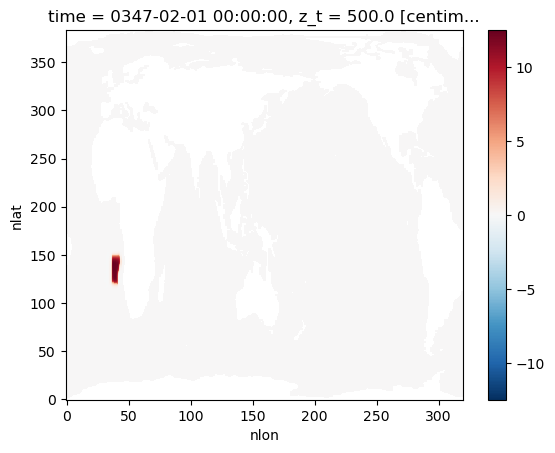

In [32]:
alk_anomaly.isel(z_t=0).plot()

In [33]:
expanded.nbytes / 1e9

0.327354116

In [34]:
expanded.nbytes / 1e9 * 12

3.9282493919999997

In [35]:
def set_encoding(ds: xr.Dataset) -> xr.Dataset:

    #ds = ds.drop_encoding()
    
    # merge encodings to include existing time encoding as well as previous compression encoding
    for name, var in ds.variables.items():

        # avoids some very irritating behaviour causing the netCDF files to be internally chunked
        if "original_shape" in ds[name].encoding:
            del ds[name].encoding["original_shape"]
        
        if np.issubdtype(var.dtype, np.floating):  # don't try to compress things that aren't floats
            ds[name].encoding["zlib"] = True
            ds[name].encoding["complevel"] = 4

        if var.ndim == 6:
            _3D_CHUNKS = (1, 1, 1, 60, 384, 320)
            #ds[name] = ds[name].chunk(_3D_CHUNKS)
            ds[name].encoding['chunksizes'] = _3D_CHUNKS
        elif var.ndim == 5:
            _2D_CHUNKS = (1, 1, 1, 384, 320)
            #ds[name] = ds[name].chunk(_2D_CHUNKS)
            ds[name].encoding['chunksizes'] = _2D_CHUNKS
    
    return ds

In [36]:
encoded = set_encoding(expanded)

In [37]:
encoded

<xarray.Dataset> Size: 327MB
Dimensions:                     (injection_date: 1, elapsed_time: 1, d2: 2,
                                 z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60,
                                 z_w_bot: 60, nlat: 384, nlon: 320,
                                 polygon_id: 1)
Coordinates: (12/64)
    time_bound                  (injection_date, elapsed_time, d2) object 16B ...
    time                        (injection_date, elapsed_time) object 8B 0347...
  * z_t                         (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                    (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                         (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                     (z_w_top) float32 240B 0.0 1e+03 ... 5.25e+05
    ...                          ...
    sflux_factor                float64 8B ...
    nsurface_t                  float64 8B ...
    nsurface_u                  float64 8B ...
  * polygon_id                  (polygon_id) int64 8B 0
  * injection_date              (injection_date) object 8B 1999-01-01 00:00:00
  * elapsed_time                (elapsed_time) timedelta64[ns] 8B 00:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/34)
    CO3                         (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    pH_3D                       (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    CO3_ALT_CO2                 (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    pH_3D_ALT_CO2               (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    co3_sat_calc                (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    co3_sat_arag                (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    ...                          ...
    ALK_ALT_CO2_zint_100m       (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    STF_ALK_ALT_CO2             (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
Attributes:
    title:             smyle-fosi.South.alk-forcing-South.250-1999-01
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-09-15 at 23:22:59.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [38]:
encoded.CO3.encoding

{'dtype': dtype('float32'),
 'source': '/glade/campaign/cesm/development/bgcwg/projects/OAE-Global-Efficiency/Mengyang_Global_OAE_Experiments/archive/smyle-fosi.South.alk-forcing-South.250-1999-01/ocn/hist/smyle-fosi.South.alk-forcing-South.250-1999-01.pop.h.0347-01.nc',
 'missing_value': 9.96921e+36,
 '_FillValue': 9.96921e+36,
 'coordinates': 'TLONG TLAT z_t time',
 'zlib': True,
 'complevel': 4,
 'chunksizes': (1, 1, 1, 60, 384, 320)}

In [39]:
encoded['pH_3D'].encoding

{'dtype': dtype('float32'),
 'source': '/glade/campaign/cesm/development/bgcwg/projects/OAE-Global-Efficiency/Mengyang_Global_OAE_Experiments/archive/smyle-fosi.South.alk-forcing-South.250-1999-01/ocn/hist/smyle-fosi.South.alk-forcing-South.250-1999-01.pop.h.0347-01.nc',
 'missing_value': 9.96921e+36,
 '_FillValue': 9.96921e+36,
 'coordinates': 'TLONG TLAT z_t time',
 'zlib': True,
 'complevel': 4,
 'chunksizes': (1, 1, 1, 60, 384, 320)}

In [40]:
def save_to_netcdf(
    ds: xr.Dataset, 
    out_filepath: str,
) -> None:
    ds.to_netcdf(out_filepath, format='NETCDF4')

In [41]:
!pwd

/glade/u/home/tnicholas/oae_dataset/ResearchGrade/compressed_perlmutter


In [41]:
encoded

<xarray.Dataset> Size: 327MB
Dimensions:                     (injection_date: 1, elapsed_time: 1, d2: 2,
                                 z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60,
                                 z_w_bot: 60, nlat: 384, nlon: 320,
                                 polygon_id: 1)
Coordinates: (12/64)
    time_bound                  (injection_date, elapsed_time, d2) object 16B ...
    time                        (injection_date, elapsed_time) object 8B 0347...
  * z_t                         (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                    (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                         (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                     (z_w_top) float32 240B 0.0 1e+03 ... 5.25e+05
    ...                          ...
    sflux_factor                float64 8B ...
    nsurface_t                  float64 8B ...
    nsurface_u                  float64 8B ...
  * polygon_id                  (polygon_id) int64 8B 0
  * injection_date              (injection_date) object 8B 1999-01-01 00:00:00
  * elapsed_time                (elapsed_time) timedelta64[ns] 8B 00:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/34)
    CO3                         (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    pH_3D                       (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    CO3_ALT_CO2                 (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    pH_3D_ALT_CO2               (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    co3_sat_calc                (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    co3_sat_arag                (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    ...                          ...
    ALK_ALT_CO2_zint_100m       (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    STF_ALK_ALT_CO2             (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
Attributes:
    title:             smyle-fosi.South.alk-forcing-South.250-1999-01
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-09-15 at 23:22:59.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [42]:
encoded.nbytes / 1e6

327.354116

In [43]:
encoded['ALK'].encoding

{'dtype': dtype('float32'),
 'source': '/glade/campaign/cesm/development/bgcwg/projects/OAE-Global-Efficiency/Mengyang_Global_OAE_Experiments/archive/smyle-fosi.South.alk-forcing-South.250-1999-01/ocn/hist/smyle-fosi.South.alk-forcing-South.250-1999-01.pop.h.0347-01.nc',
 'missing_value': 9.96921e+36,
 '_FillValue': 9.96921e+36,
 'coordinates': 'TLONG TLAT z_t time',
 'zlib': True,
 'complevel': 4,
 'chunksizes': (1, 1, 1, 60, 384, 320)}

In [44]:
save_to_netcdf(
    encoded, 
    out_filepath='/glade/u/home/tnicholas/oae_dataset/ResearchGrade/compressed_perlmutter/test.nc',
)

NameError: name 'save_to_netcdf' is not defined

In [ ]:
!pwd

In [42]:
!du -ch test.nc

214M	test.nc
214M	total


In [47]:
214 * 690 * 4 * 180 / 1e6

106.3152

In [93]:
192 * 690 * 4 * 180 / 1e6

95.3856

### Check it re-opens okay

In [48]:
reopened = xr.open_dataset('test.nc', chunks={})

In [49]:
reopened

<xarray.Dataset> Size: 327MB
Dimensions:                     (injection_date: 1, elapsed_time: 1, d2: 2,
                                 z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60,
                                 z_w_bot: 60, nlat: 384, nlon: 320,
                                 polygon_id: 1)
Coordinates: (12/64)
    time_bound                  (injection_date, elapsed_time, d2) object 16B dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    time                        (injection_date, elapsed_time) object 8B dask.array<chunksize=(1, 1), meta=np.ndarray>
  * z_t                         (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                    (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                         (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                     (z_w_top) float32 240B 0.0 1e+03 ... 5.25e+05
    ...                          ...
    sflux_factor                float64 8B ...
    nsurface_t                  float64 8B ...
    nsurface_u                  float64 8B ...
  * polygon_id                  (polygon_id) int64 8B 0
  * injection_date              (injection_date) object 8B 1999-01-01 00:00:00
  * elapsed_time                (elapsed_time) timedelta64[ns] 8B 00:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/34)
    CO3                         (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    pH_3D                       (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    CO3_ALT_CO2                 (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    pH_3D_ALT_CO2               (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    co3_sat_calc                (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    co3_sat_arag                (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    ...                          ...
    ALK_ALT_CO2_zint_100m       (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    STF_ALK_ALT_CO2             (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_DIC          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_DIC_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_ALK          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_ALK_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
Attributes:
    title:             smyle-fosi.South.alk-forcing-South.250-1999-01
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-09-15 at 23:22:59.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [50]:
reopened.chunksizes

Frozen({'injection_date': (1,), 'elapsed_time': (1,), 'd2': (2,), 'z_t': (60,), 'z_w': (60,), 'nlat': (384,), 'nlon': (320,), 'polygon_id': (1,)})

In [51]:
!pwd

/glade/u/home/tnicholas/oae_dataset/ResearchGrade/compressed_perlmutter


In [52]:
reopened['pH_3D'].encoding

{'dtype': dtype('float32'),
 'zlib': True,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': True,
 'complevel': 4,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1, 1, 1, 60, 384, 320),
 'preferred_chunks': {'polygon_id': 1,
  'injection_date': 1,
  'elapsed_time': 1,
  'z_t': 60,
  'nlat': 384,
  'nlon': 320},
 'source': '/glade/u/home/tnicholas/oae_dataset/ResearchGrade/compressed_perlmutter/test.nc',
 'original_shape': (1, 1, 1, 60, 384, 320),
 'missing_value': 9.96921e+36,
 '_FillValue': 9.96921e+36,
 'coordinates': 'TLONG TLAT z_t time'}

In [53]:
reopened.load()

<xarray.Dataset> Size: 327MB
Dimensions:                     (injection_date: 1, elapsed_time: 1, d2: 2,
                                 z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60,
                                 z_w_bot: 60, nlat: 384, nlon: 320,
                                 polygon_id: 1)
Coordinates: (12/64)
    time_bound                  (injection_date, elapsed_time, d2) object 16B ...
    time                        (injection_date, elapsed_time) object 8B 0347...
  * z_t                         (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                    (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                         (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                     (z_w_top) float32 240B 0.0 1e+03 ... 5.25e+05
    ...                          ...
    sflux_factor                float64 8B 0.1
    nsurface_t                  float64 8B 8.61e+04
    nsurface_u                  float64 8B 8.297e+04
  * polygon_id                  (polygon_id) int64 8B 0
  * injection_date              (injection_date) object 8B 1999-01-01 00:00:00
  * elapsed_time                (elapsed_time) timedelta64[ns] 8B 00:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables: (12/34)
    CO3                         (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    pH_3D                       (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    CO3_ALT_CO2                 (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    pH_3D_ALT_CO2               (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    co3_sat_calc                (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    co3_sat_arag                (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 29MB ...
    ...                          ...
    ALK_ALT_CO2_zint_100m       (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    STF_ALK_ALT_CO2             (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_DIC_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
    tend_zint_100m_ALK_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 492kB ...
Attributes:
    title:             smyle-fosi.South.alk-forcing-South.250-1999-01
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-09-15 at 23:22:59.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

### Whole pipeline for any task

In [43]:
out_path_prefix = "/glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/ResearchGrade/compressed4/"

In [44]:
def open_compress_and_save_file(
    filepath: str,
    original_polygon_id: str,
    new_polygon_id: str,
    injection_month: str,
    region: str,
) -> None:

    # parse filepath to get year and month
    subst = re.findall(r"\d{4}-\d{2}", filepath)[-1]
    year, month = subst.split('-')

    print(f"Processing polygon_id={original_polygon_id}, injection_month={injection_month}, region={region}, year={year}, month={month}")
    
    filename = Path(filepath).name
    
    ds = open_single_file(
        filepath=filepath,
        # year=year, 
        # month=month,
        original_polygon_id=original_polygon_id,
        injection_month=injection_month,
        region=region,
    )

    ds_with_polygon_id = add_polygon_id_coord(ds, new_polygon_id=new_polygon_id)

    ds_with_injection_date = add_injection_date_coord(ds_with_polygon_id, filename=ds.attrs['title'])
    
    ds_with_elapsed_time = add_elapsed_time_coord(ds_with_injection_date, year=year, month=month)

    ds_expanded = expand_ensemble_dims(ds_with_elapsed_time)

    ds_encoded = set_encoding(ds_expanded)

    out_dir = out_path_prefix + f"{new_polygon_id}/{injection_month}/"
    
    # # if the directory doesn't exist then make it
    Path(out_dir).mkdir(parents=True, exist_ok=True)

    out_filepath = out_dir + f"alk-forcing.{new_polygon_id}-1999-{injection_month}.pop.h.{year}-{month}.nc"
    
    save_to_netcdf(
        ds_encoded,#.drop_vars('HCO3'),
        out_filepath=out_filepath,
    )

    ds.close()
    ds_with_polygon_id.close()
    ds_with_injection_date.close()
    ds_with_elapsed_time.close()
    ds_expanded.close()
    ds_encoded.close()
    ds_encoded.close()

In [50]:
open_compress_and_save_file(
    filepath=data_dir + f'smyle-fosi.South.alk-forcing-South.000-1999-01/ocn/hist/smyle-fosi.South.alk-forcing-South.000-1999-01.pop.h.0347-01.nc',
    original_polygon_id='000',
    new_polygon_id='000',
    injection_month='01',
    region='South',
)

Processing polygon_id=000, injection_month=01, region=South, year=0347, month=01


In [69]:
perlmutter_data_dir

'/glade/campaign/cesm/development/bgcwg/projects/OAE-Global-Efficiency/Perlmutter-Integrations/'

In [45]:
@dask.delayed
def open_compress_and_save_all_files_for_one_simulation(
    original_polygon_id: str,
    new_polygon_id: str,
    injection_month: str,
    region: str,
) -> list[dask.delayed]:

    if has_perlmutter_integration(new_polygon_id=new_polygon_id, injection_month=injection_month):
        fileglob = perlmutter_data_dir + f'smyle.oae-map.{region}.{original_polygon_id}.1999-{injection_month}-01.001/ocn/hist/smyle.oae-map.{region}.{original_polygon_id}.1999-{injection_month}-01.001.pop.h.*.nc'
    else:
        fileglob = data_dir + f'smyle-fosi.{region}.alk-forcing-{region}.{original_polygon_id}-1999-{injection_month}/ocn/hist/smyle-fosi.{region}.alk-forcing-{region}.{original_polygon_id}-1999-{injection_month}.pop.h.*.nc'
    
    #print(fileglob)
    
    filepaths = sorted(glob.glob(fileglob))

    if not filepaths:
        raise ValueError(f"no files found for glob {fileglob}")
    
    #print(filepaths)
    
    [
        open_compress_and_save_file(
            filepath=filepath,
            original_polygon_id=original_polygon_id,
            new_polygon_id=new_polygon_id,
            injection_month=injection_month,
            region=region,
        )
        for filepath in filepaths
    ]

### Create cluster

In [46]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

In [47]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'oae-dataset-compression',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = '/local_scratch/pbs.$PBS_JOBID/dask/spill',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '24:00:00',
    interface = 'ext',
    job_extra_directives=['-V'],
)

2024-10-04 09:34:41,897 - tornado.application - ERROR - Uncaught exception GET /status/ws (::1)
HTTPServerRequest(protocol='http', host='jupyterhub.hpc.ucar.edu', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/glade/work/tnicholas/conda-envs/dev3.10/lib/python3.10/site-packages/tornado/websocket.py", line 938, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/glade/work/tnicholas/conda-envs/dev3.10/lib/python3.10/site-packages/tornado/web.py", line 3301, in wrapper
    return method(self, *args, **kwargs)
  File "/glade/work/tnicholas/conda-envs/dev3.10/lib/python3.10/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.
2024-10-04 09:44:25,307 - distributed.scheduler - ERROR - Task open_compress_and_save_all_files_for_one_simulatio-4fd05a9c-55c4-49fd-a7e8-e2d

In [48]:
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tnicholas/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.86:38367,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tnicholas/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [49]:
print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N oae-dataset-compression
#PBS -q casper
#PBS -A P93300670
#PBS -l select=1:ncpus=1:mem=8GB
#PBS -l walltime=24:00:00
#PBS -V

/glade/work/tnicholas/conda-envs/dev3.10/bin/python -m distributed.cli.dask_worker tcp://128.117.208.86:38367 --name dummy-name --nthreads 1 --memory-limit 8.00GiB --nanny --death-timeout 60 --local-directory /local_scratch/pbs.$PBS_JOBID/dask/spill --interface ext



In [50]:
# Create the client to load the Dashboard
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tnicholas/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tnicholas/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.86:38367,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tnicholas/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [51]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tnicholas/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tnicholas/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.86:38367,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tnicholas/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [123]:
cluster.scale(2)

In [124]:
cluster.scale(50)

In [48]:
cluster.scale(200)

In [60]:
cluster.scale(340)

In [52]:
cluster.scale(400)

In [62]:
1

1

In [90]:
# Block progress until workers have spawned (typically only in demos and benchmarks!)
client.wait_for_workers(2)

### Try for one simulation

In [151]:
tasks = open_compress_and_save_all_files_for_one_simulation(
    original_polygon_id='000',
    new_polygon_id='000',
    injection_month='04',
    region='North_Atlantic_basin',
)

In [152]:
tasks

Delayed('open_compress_and_save_all_files_for_one_simulatio-8ef432fd-d368-4d51-bf11-b160eedf2a06')

In [121]:
len(tasks)

TypeError: Delayed objects of unspecified length have no len()

In [153]:
dask.persist(tasks, retries=2)

(Delayed('open_compress_and_save_all_files_for_one_simulatio-8ef432fd-d368-4d51-bf11-b160eedf2a06'),)

submitted at 12:00am

180/180 files done by 12:30pm-ish

In [132]:
40 * 690 * 4 / 60 / 359

5.125348189415042

In [134]:
13e9 * 690 * 4 / 1e12

35.88

In [132]:
69e6 * 180 * 690 * 4 / 1e12 

34.2792

### Regions

In [53]:
def polygon_ids_as_strings(s: slice) -> list[str]:
    """Generate list of all polygon ids of the form '001' in this slice."""
    values = np.arange(s.start, s.stop)

    def left_pad_with_zeros(number, width):
        return f"{number:0{width}}"
        
    return [left_pad_with_zeros(val, 3) for val in values]

Try to do this in the same order that we generated the file with the polygon masks in it, so the ids match what Shane already has

150 in "Atlantic"

In [78]:
len(
    glob.glob(
        '/glade/campaign/cesm/development/bgcwg/projects/OAE-Global-Efficiency/Mengyang_Global_OAE_Experiments/archive/smyle-fosi.North_Atlantic*'
    )
)

602

(there are two random extra directories that we can ignore)

In [126]:
atlantic_delayed_compression_tasks = [
    open_compress_and_save_all_files_for_one_simulation(
        original_polygon_id=polygon_id,
        injection_month=injection_month,
        region='North_Atlantic_basin',
        new_polygon_id=polygon_id,  # use original for this batch
    )
    for polygon_id in polygon_ids_as_strings(slice(0, 150))
    for injection_month in ['01', '04', '07', '10']
]

In [127]:
atlantic_futures = dask.persist(*atlantic_delayed_compression_tasks, retries=3)

200 in "Pacific"

In [129]:
len(
    glob.glob(
        '/glade/campaign/cesm/development/bgcwg/projects/OAE-Global-Efficiency/Mengyang_Global_OAE_Experiments/archive/smyle-fosi.North_Pacific*'
    )
)

800

In [130]:
pacific_delayed_compression_tasks = [
    open_compress_and_save_all_files_for_one_simulation(
        original_polygon_id=polygon_id,
        injection_month=injection_month,
        region='North_Pacific_basin',
        new_polygon_id=new_polygon_id,
    )
    for polygon_id, new_polygon_id in zip(polygon_ids_as_strings(slice(0, 200)), polygon_ids_as_strings(slice(150, 350)))
    for injection_month in ['01', '04', '07', '10']
]

In [131]:
pacific_futures = dask.persist(*pacific_delayed_compression_tasks, retries=3)

350 polygons launched on 348 workers at 1:27am Sep 26th

696 / 1400 tasks completed by 9:32am

----- start from here ----

300 in "South"

In [57]:
south_delayed_compression_tasks1 = [
    open_compress_and_save_all_files_for_one_simulation(
        original_polygon_id=polygon_id,
        injection_month=injection_month,
        region='South',
        new_polygon_id=new_polygon_id,
    )
    for polygon_id, new_polygon_id in zip(polygon_ids_as_strings(slice(0, 100)), polygon_ids_as_strings(slice(350, 450)))
    for injection_month in ['01', '04', '07', '10']
]

In [58]:
south_futures1 = dask.persist(*south_delayed_compression_tasks1, retries=3)

In [59]:
south_delayed_compression_tasks2 = [
    open_compress_and_save_all_files_for_one_simulation(
        original_polygon_id=polygon_id,
        injection_month=injection_month,
        region='South',
        new_polygon_id=new_polygon_id,
    )
    for polygon_id, new_polygon_id in zip(polygon_ids_as_strings(slice(100, 200)), polygon_ids_as_strings(slice(450, 550)))
    for injection_month in ['01', '04', '07', '10']
]

In [60]:
south_futures2 = dask.persist(*south_delayed_compression_tasks2, retries=3)

200 submitted on 359 workers at 12:06am 29th September

---- start from here ----

In [54]:
south_delayed_compression_tasks3 = [
    open_compress_and_save_all_files_for_one_simulation(
        original_polygon_id=polygon_id,
        injection_month=injection_month,
        region='South',
        new_polygon_id=new_polygon_id,
    )
    for polygon_id, new_polygon_id in zip(polygon_ids_as_strings(slice(200, 300)), polygon_ids_as_strings(slice(550, 650)))
    for injection_month in ['01', '04', '07', '10']
]

In [55]:
south_futures3 = dask.persist(*south_delayed_compression_tasks3, retries=3)

40 in "Southern_Ocean"

In [56]:
len(
    glob.glob(
        '/glade/campaign/cesm/development/bgcwg/projects/OAE-Global-Efficiency/Mengyang_Global_OAE_Experiments/archive/smyle-fosi.Southern_Ocean*'
    )
)

160

In [57]:
1

1

In [58]:
southern_ocean_delayed_compression_tasks = [
    open_compress_and_save_all_files_for_one_simulation(
        original_polygon_id=polygon_id,
        injection_month=injection_month,
        region='Southern_Ocean',
        new_polygon_id=new_polygon_id,
    )
    for polygon_id, new_polygon_id in zip(polygon_ids_as_strings(slice(0, 40)), polygon_ids_as_strings(slice(650, 690)))
    for injection_month in ['01', '04', '07', '10']
]

In [59]:
southern_ocean_futures = dask.persist(*southern_ocean_delayed_compression_tasks, retries=3)

140 polygons submitted on 200 8GB workers at 12:52pm on 29th Sep

In [60]:
cluster.scale(0)

In [61]:
cluster.close()

In [62]:
client.close()

Uploading from one login node at ~180MiB/s

Have ~37TB of data to upload

In [157]:
(37e12 / 190e6) / 3600

54.093567251461984

i.e. 54 hours to upload all polygon data from one login node